# FERMI DATA: Conditional Flow-Matching
We use Simplified Conditional Flow-matching (Tong et al. 2023) with a MLP.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt 

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_MLP_CondFlowMatch as Configs

configs = Configs(dataset = '../data/fermi/fermi_data_galactic_coord.npy',
                  features = ['theta', 'phi', 'energy'],
                  preprocess=['normalize', 'logit_transform', 'standardize'], 
                  cuts = {'theta': [-10., 10.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                  data_split_fracs = [1.0, 0.0, 0.0],
                  epochs = 100,
                  batch_size = 10000,
                  lr = 1e-3,
                  dim_hidden = 64, 
                  sigma = 0.0,
                  solver='midpoint',
                  num_sampling_steps=500)

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

#...define dataset :

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.deep_nets import MLP
from DynGenModels.dynamics.cnf.flowmatch import SimplifiedCondFlowMatching

dataset = FermiDataset(configs)
dataloader = FermiDataLoader(dataset, configs)
net = MLP(configs)
dynamics = SimplifiedCondFlowMatching(net, configs)
cfm = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
cfm.train()

#=================================================================================
INFO: created directory: ../results/MLP.fermi_galactic_center_2023.10.04_21h26__2
#=================================================================================
+--------------------+-------------------------------------------------+
| Parameters         | Values                                          |
+--------------------+-------------------------------------------------+
| data_name          | fermi_galactic_center                           |
| dataset            | ../data/fermi/fermi_data_galactic_coord.npy     |
| features           | ['theta', 'phi', 'energy']                      |
| dim_input          | 3                                               |
| preprocess         | ['normalize', 'logit_transform', 'standardize'] |
| cuts               | theta: [-10.0, 10.0]                            |
|                    | phi: [4.0, 10.0]                                |
|                    |

epochs:   0%|          | 0/100 [00:00<?, ?it/s]

In [2]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData 

pipeline = FlowMatchPipeline(trained_model=cfm, 
                             source_input=torch.randn(50000, 3),
                             configs=configs, 
                             solver = 'midpoint',
                             num_sampling_steps=500,
                             postprocessor=PostProcessFermiData)

INFO: neural ODE solver with midpoint method and steps=500


/Users/dario/anaconda3/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


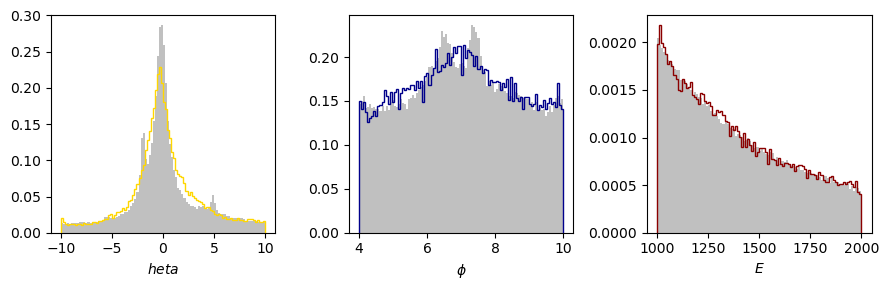

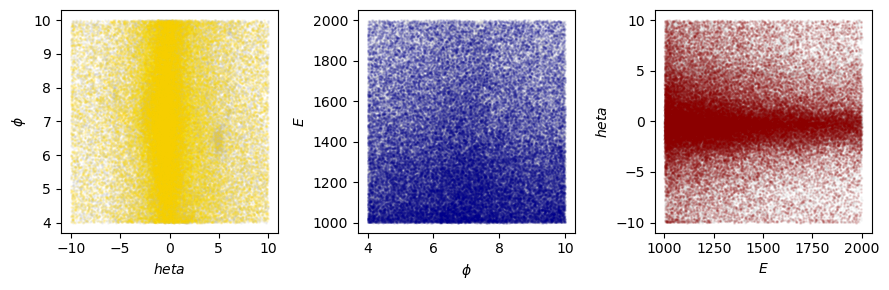

In [3]:
coord = ['$\theta$', '$\phi$', '$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target[:50000, i], dataset.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()


# FERMI DATA: Normalizing flows 
for the flow we use a MAF with affine transforms

In [1]:
import matplotlib.pyplot as plt

from DynGenModels.trainer.trainer import DynGenModelTrainer
from DynGenModels.configs.fermi_configs import FermiGCE_MAF_RQS_NormFlow as Configs


configs = Configs(dataset = '../data/fermi/fermi_data_galactic_coord.npy',
                features = ['theta', 'phi', 'energy'],
                preprocess = ['normalize', 'logit_transform', 'standardize'],
                cuts = {'theta': [-20., 20.], 'phi': [4., 10.], 'energy': [1000, 2000]},
                data_split_fracs = [0.6, 0.1, 0.3],
                epochs = 50,
                early_stopping=20,
                batch_size = 512,
                warmup_epochs = 20,
                lr = 1e-3,
                dim_hidden = 128, 
                device = 'cpu',
                seed = 12345,
                num_transforms = 5,
                num_gen_samples = 58000
                )

#...set working directory for results:

configs.set_workdir(path='../results', save_config=True)

#...define dataset :

from DynGenModels.datamodules.fermi.datasets import FermiDataset 
from DynGenModels.datamodules.fermi.dataloader import FermiDataLoader 
from DynGenModels.models.nflow_nets import MAFPiecewiseRQS
from DynGenModels.dynamics.nf.normflows import NormalizingFlow

dataset = FermiDataset(configs)
dataloader = FermiDataLoader(dataset, configs)
net = MAFPiecewiseRQS(configs)
dynamics = NormalizingFlow(net, configs)
maf = DynGenModelTrainer(dynamics=dynamics, dataloader=dataloader, configs=configs)
maf.train()

#=====================================================================================
INFO: created directory: ../results/MAF_RQS.fermi_galactic_center_2023.09.29_16h32__1
#=====================================================================================
+---------------------+-------------------------------------------------+
| Parameters          | Values                                          |
+---------------------+-------------------------------------------------+
| data_name           | fermi_galactic_center                           |
| dataset             | ../data/fermi/fermi_data_galactic_coord.npy     |
| features            | ['theta', 'phi', 'energy']                      |
| dim_input           | 3                                               |
| preprocess          | ['normalize', 'logit_transform', 'standardize'] |
| cuts                | theta: [-20.0, 20.0]                            |
|                     | phi: [4.0, 10.0]                                |


epochs:   0%|          | 0/50 [00:00<?, ?it/s]

	 test loss: 0.007477868188246197  (min loss: 0.007477868188246197)
	 test loss: 0.007324377785931615  (min loss: 0.007324377785931615)
	 test loss: 0.00730877509150833  (min loss: 0.007304907103427749)


INFO: post-processing sampled data with ['inverse_standardize', 'inverse_logit_transform', 'inverse_normalize']


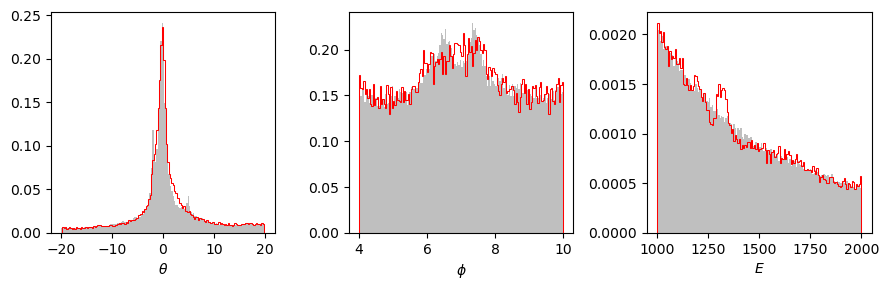

In [2]:
#...sample from model

from DynGenModels.pipelines.SamplingPipeline import NormFlowPipeline 
from DynGenModels.datamodules.fermi.dataprocess import PostProcessFermiData

pipeline = NormFlowPipeline(trained_model=maf, configs=configs, postprocessor=PostProcessFermiData)


In [ ]:
coord = ['$\theta$', '$\phi$', '$E$']
color=['gold', 'darkblue', 'darkred']

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i in range(3):
    ax[i].hist(dataset.target[..., i], bins=100, color='silver', density=True)
    ax[i].hist(pipeline.target[..., i], bins=100, color=color[i], histtype='step', density=True)
    ax[i].set_xlabel(coord[i])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
for i, j in [(0,1), (1,2), (2,0)]:
    ax[i].scatter(dataset.target[:50000, i], dataset.target[:50000, j], s=1, alpha=0.1, c='silver')
    ax[i].scatter(pipeline.target[:50000, i], pipeline.target[:50000, j], s=1, alpha=0.1, c=color[i])
    ax[i].set_xlabel(coord[i])
    ax[i].set_ylabel(coord[j])
plt.tight_layout()
plt.show()